<a href="https://colab.research.google.com/github/KarthikCU1054/SOEN_6841/blob/main/AI_Project_Plant_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import asarray
from PIL import Image
from google.colab import drive
import pathlib
import os
from tqdm import tqdm
import cv2
import time
import torch.optim as optim
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [ ]:

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder('/content/drive/MyDrive/plant_leaf_dataset/dataset2/', transform=Compose([Resize((224,224)),ToTensor()]))
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

trainingDataLoader = torch.utils.data.DataLoader(
    datasets['train'],
    batch_size=64,
    shuffle=False
)

testingDataLoader = torch.utils.data.DataLoader(
    datasets['val'],
    batch_size=64,
    shuffle=False
)

2277
1707
570
Dataset ImageFolder
    Number of datapoints: 2277
    Root location: /content/drive/MyDrive/plant_leaf_dataset/dataset2/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


torch.Size([64, 3, 224, 224])
tensor(10)


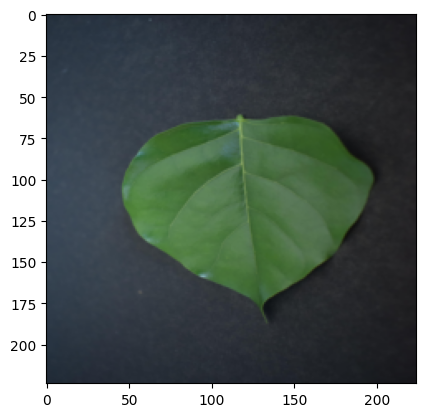

In [ ]:
batch = next(iter(trainingDataLoader))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(2, 1, 0))
print(batch[1][0])

In [ ]:
# Hyper-parameters
num_epochs = 10
batch_size = 5
learning_rate = 0.001

In [ ]:
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
#-

In [ ]:
print(device)

cpu


In [ ]:
n_total_steps = len(trainingDataLoader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainingDataLoader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)


Epoch [1/10], Step [1/27], Loss: 2.5100
Epoch [1/10], Step [2/27], Loss: 2.5040
Epoch [1/10], Step [3/27], Loss: 2.5307
Epoch [1/10], Step [4/27], Loss: 2.4391
Epoch [1/10], Step [5/27], Loss: 2.4346
Epoch [1/10], Step [6/27], Loss: 2.4107
Epoch [1/10], Step [7/27], Loss: 2.4412
Epoch [1/10], Step [8/27], Loss: 2.3762
Epoch [1/10], Step [9/27], Loss: 2.4340
Epoch [1/10], Step [10/27], Loss: 2.4181
Epoch [1/10], Step [11/27], Loss: 2.3202
Epoch [1/10], Step [12/27], Loss: 2.4604
Epoch [1/10], Step [13/27], Loss: 2.3409
Epoch [1/10], Step [14/27], Loss: 2.3694
Epoch [1/10], Step [15/27], Loss: 2.4091
Epoch [1/10], Step [16/27], Loss: 2.3703
Epoch [1/10], Step [17/27], Loss: 2.2941
Epoch [1/10], Step [18/27], Loss: 2.2642
Epoch [1/10], Step [19/27], Loss: 2.3276
Epoch [1/10], Step [20/27], Loss: 2.2231
Epoch [1/10], Step [21/27], Loss: 2.2880
Epoch [1/10], Step [22/27], Loss: 2.2994
Epoch [1/10], Step [23/27], Loss: 2.2526
Epoch [1/10], Step [24/27], Loss: 2.2632
Epoch [1/10], Step [25/27

In [ ]:
classes = (1,2,3,4,5,6,7,8,9,10,11)
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(4)]
    n_class_samples = [0 for i in range(4)]
    for images, labels in testingDataLoader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(4):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')